In [1]:
import numpy as np
from Utils.discrete_family import discrete_family
from Utils.barrier_affine import solve_barrier_tree
from CART import RegressionTree
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal as mvn
from Utils.plotting import  *

In [2]:
class TreeNode:
    def __init__(self, feature_index=None, threshold=None, pos=None,
                 left=None, right=None, value=None, prev_branch=None,
                 prev_node=None, membership=None, depth=0, which=None,
                 randomization=None):
        self.feature_index = feature_index  # Index of the feature to split on
        self.threshold = threshold  # Threshold value to split on
        self.pos = pos # Position (the ascending order) of the split value
        self.left = left  # Left child node
        self.right = right  # Right child node
        self.value = value  # Value for leaf nodes (mean of target values)
        self.prev_branch = prev_branch # List of (j, s, e) depicting a previous branch
        self.prev_node = prev_node
        self.membership = membership
        self.depth = depth
        self.randomization = randomization

class RegressionTree:
    def __init__(self, min_samples_split=2, max_depth=float('inf')):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.root = self._build_tree(X, y)
    
    def _build_tree(self, X, y, depth=0, membership=None, 
                    prev_branch=None):
        """
        A recursive private function to build the tree 
        by repeatedly splitting 
        :param X: the covariates of the previous sub-region
        :param y: the response of the previous sub-region
        :param depth: depth of the previous split
        :return: a node characterizing this split and fitted value
        """
        num_samples, num_features = X.shape
        if depth == 0:
            membership = np.ones((num_samples,))
        else:
            assert membership is not None
        
        if prev_branch is None:
            prev_branch = []
            #print("pbc:", prev_branch)
            
        if num_samples >= self.min_samples_split and depth <= self.max_depth:
            best_split = self._get_best_split(X, y, num_features)
            feature_idx = best_split["feature_index"]
            threshold = best_split["threshold"]
            pos = best_split["position"]
            left_mbsp = self.X[:,feature_idx] <= threshold
            right_mbsp = self.X[:,feature_idx] > threshold
            left_mbsp = left_mbsp * membership # n x 1 logical vector
            right_mbsp = right_mbsp * membership # n x 1 logical vector
            # if best_split["gain"] > 0:
            left_prev_branch = prev_branch.copy()
            left_prev_branch.append([feature_idx, pos, 0])
            right_prev_branch = prev_branch.copy()
            right_prev_branch.append([feature_idx, pos, 1])
            #print(left_prev_branch)
            #print(right_prev_branch)
            left_subtree \
                = self._build_tree(best_split["X_left"],
                                   best_split["y_left"], 
                                   depth + 1, 
                                   membership=left_mbsp,
                                   prev_branch=left_prev_branch)
            right_subtree \
                = self._build_tree(best_split["X_right"],
                                   best_split["y_right"], 
                                   depth + 1,
                                   membership=right_mbsp,
                                   prev_branch=right_prev_branch)
            return TreeNode(feature_index=best_split["feature_index"],
                            threshold=best_split["threshold"],
                            pos=pos,
                            left=left_subtree, right=right_subtree,
                            membership=membership, depth=depth,
                            randomization=best_split["randomization"],
                            prev_branch=prev_branch)
        leaf_value = self._calculate_leaf_value(y)
        return TreeNode(value=leaf_value, membership=membership,
                        depth=depth)

    def _get_best_split(self, X, y, num_features, sd_rand=1):
        """
        Input (X, y) of a (potentially sub-)region, return information about 
        the best split on this regions
        Assuming no ties in features
        :param X: the (sub-)region's covariates
        :param y: the (sub-)region's response
        :param num_features: dimension of X
        :return: a dictionary containing 
                {split_feature_idx, (numerical) splitting_threshold,
                split_position, left_sub_region, right_sub_region,
                gain}
        """
        best_split = {}
        min_loss = float('inf')
        num_sample = X.shape[0]
        randomization = np.zeros((num_sample-1, num_features))
        
        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            feature_values_sorted = feature_values.copy()
            feature_values_sorted.sort()
            for i in range(len(feature_values_sorted)-1):
                threshold = feature_values_sorted[i]
                X_left, y_left, X_right, y_right = self._split(X, y, feature_index, threshold)
                if len(X_left) > 0 and len(X_right) > 0:
                    omega = np.random.normal(scale=sd_rand)
                    randomization[i, feature_index] = omega
                    loss = self._calculate_loss(y_left, y_right, omega)
                    if loss < min_loss:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["position"] = i
                        best_split["X_left"] = X_left
                        best_split["y_left"] = y_left
                        best_split["X_right"] = X_right
                        best_split["y_right"] = y_right
                        best_split["loss"] = loss
                        best_split["randomization"] = randomization
                        #best_split[""]
                        min_loss = loss
        return best_split

    def _split(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

    def _calculate_information_gain(self, y, y_left, y_right):
        var_total = np.var(y) * len(y)
        var_left = np.var(y_left) * len(y_left)
        var_right = np.var(y_right) * len(y_right)
        return var_total - (var_left + var_right)
    
    def _calculate_loss(self, y_left, y_right, randomization):
        n1 = len(y_left)
        n2 = len(y_right)
        loss = - n1 * np.mean(y_left)**2 - n2 * np.mean(y_right)**2 + randomization
        
        return loss
    
    # 
    def _calculate_leaf_value(self, y):
        """
        :param y: the response of the previous sub-region
        :return: the mean of the region
        """
        return np.mean(y)

    def predict(self, X):
        """
        :param X: the test dataset
        :return: fitted values
        """
        return np.array([self._predict(sample, self.root) for sample in X])

    def _predict(self, sample, tree):
        """
        Recursively searching the tree for the surrounding region of `sample`
        :param sample: the input covariates
        :param tree: the trained tree
        :return: fitted y value of `sample`
        """
        if tree.value is not None:
            return tree.value
        feature_value = sample[tree.feature_index]
        if feature_value <= tree.threshold:
            return self._predict(sample, tree.left)
        else:
            return self._predict(sample, tree.right)
    
    def _approx_log_reference(self, node, grid, nuisance,
                              contrast, norm_contrast, sd=1):
        ## TODO: 0. grid is a grid for eta'Y / (sd * norm_contrast);
        ##          first reconstruct eta'Y and then reconstruct Q
        ## TODO: 1. reconstruct Q from the grid
        ## TODO: 2. Perform Laplace approximation for each grid, 
        #           and for each node split
        ## TODO: 3. Add back the constant term omitted in Laplace Approximation
        ## TODO: 4. Return reference measure
    
        prev_branch = node.prev_branch.copy()
        current_depth = node.depth
        ref_hat = np.zeros_like(grid)
        
        ## TODO: Move the node according to branch when evaluating integrals
        node = self.root
        
        # norm = np.linalg.norm(contrast)
        depth = 0
        
        while depth <= current_depth:
            for g_idx, g in enumerate(grid):
                y_grid = g * sd**2 * norm_contrast + nuisance
                # TODO: Account for depth here
                # Subsetting the covariates to this current node
                X = self.X[node.membership.astype(bool)]
                y_g = y_grid[node.membership.astype(bool)]
                y_node = self.y[node.membership.astype(bool)]
                y_left = y_grid[node.left.membership.astype(bool)]
                y_right = y_grid[node.right.membership.astype(bool)]
                y_left_obs = self.y[node.left.membership.astype(bool)]
                y_right_obs = self.y[node.right.membership.astype(bool)]
                optimal_loss = self._calculate_loss(y_left, y_right,
                                                    randomization=0)
                opt_loss_obs = self._calculate_loss(y_left_obs, y_right_obs,
                                                    randomization=0)
                j_opt = node.feature_index  # j^*
                s_opt = node.pos            # s^*
                randomization = node.randomization
                S_total, J_total = randomization.shape
                implied_mean = []
                observed_opt = []
    
                # TODO: Add a layer to account for depth of the tree
                for j in range(J_total):
                    feature_values = X[:, j]
                    feature_values_sorted = feature_values.copy()
                    feature_values_sorted.sort()
                    for s in range(S_total - 1):
                        if not (j == j_opt and s == s_opt):
                            threshold = feature_values_sorted[s]
                            X_left, y_left, X_right, y_right \
                                = self._split(X, y_g, j, threshold)
                            implied_mean_s_j\
                                = optimal_loss - self._calculate_loss(y_left,
                                                                      y_right,
                                                                    randomization=0)
                            # The split of the actually observed Y
                            X_left_o, y_left_o, X_right_o, y_right_o \
                                = self._split(X, y_node, j, threshold)
                            print(y_left_o.shape)
                            print(y_right_o.shape)
                            observed_opt_s_j = (opt_loss_obs -
                                                self._calculate_loss(y_left_o,
                                                                     y_right_o,
                                                                    randomization=0)
                                                + (randomization[s_opt, j_opt] - 
                                                   randomization[s, j]))
                            print("s:", s, "j:", j, "sopt:", s_opt, "jopt:", j_opt)
                            
                            # Record the implied mean 
                            # and observed optimization variable
                            implied_mean.append(implied_mean_s_j)
                            observed_opt.append(observed_opt_s_j)
    
                # The implied mean is given by the optimal loss minus
                # the loss at each split
                implied_mean = np.array(implied_mean)
                observed_opt = np.array(observed_opt)
                
                # dimension of the optimization variable
                n_opt = len(implied_mean)
                implied_cov = np.ones((n_opt, n_opt)) + np.eye(n_opt)
                prec = np.eye(n_opt) - np.ones((n_opt, n_opt)) / (n_opt + 1)
                
                # TODO: what is a feasible point?
                # TODO: Need to have access to the observed opt var
                #       where we actually pass in g = eta'Y.
                print("Implied mean", implied_mean)
                print("feasible point", observed_opt)
                print("prec", prec)
                # Approximate the selection probability
                sel_prob, _, _ = solve_barrier_tree(Q=implied_mean, 
                                              precision = prec,
                                              feasible_point=None)
                const_term = (implied_mean).T.dot(prec).dot(implied_mean) / 2
                ref_hat[g_idx] += ( - sel_prob - const_term)
    
            # Move to the next layer
            if depth < current_depth:
                dir = prev_branch[depth][2]
                if dir == 0:
                    node = node.left # Depend on where the branch demands
                else:
                    node = node.right
                depth += 1
            else:
                depth += 1 # Exit the loop if targeting depth achieved
    
        return np.array(ref_hat)
        
    def split_inference(self, node, ngrid = 1000, ncoarse=20, sd=1,
                        level=0.9):
        """
        Inference for a split of a node 
        :param node: the node whose split is of interest
        :return: p-values for difference in mean 
        """
        # First determine the projection direction
        left_membership = node.left.membership
        right_membership = node.right.membership
        contrast = left_membership / np.sum(left_membership) - right_membership / np.sum(right_membership)
        
        norm_contrast = contrast / (np.linalg.norm(contrast) * sd)

        # Using the normalized contrast in practice
        # for scale-free grid approximation
        observed_target = norm_contrast @ self.y
        # The nuisance parameter is defined the same way
        # as on papers
        nuisance = (self.y - np.linalg.outer(contrast,contrast)
                    @ self.y / (np.linalg.norm(contrast)**2))

        stat_grid = np.linspace(-15, 15, num=ngrid)
    
        if ncoarse is not None:
            coarse_grid = np.linspace(-15, 15, ncoarse)
            eval_grid = coarse_grid
        else:
            eval_grid = stat_grid
        
        # Evaluate reference measure (selection prob.) over stat_grid
        ref = self._approx_log_reference(node = node,
                                         grid = eval_grid, 
                                         nuisance = nuisance,
                                         contrast = contrast, 
                                         norm_contrast = norm_contrast, sd=1)
    
        if ncoarse is None:
            logWeights = np.zeros((ngrid,))
            for g in range(ngrid):
                # Evaluate the log pdf as a sum of (log) gaussian pdf 
                # and (log) reference measure
                # TODO: Check if the original exp. fam. density is correct
                logWeights[g] = (- 0.5 * (stat_grid[g]) ** 2 + ref[g])
            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)
            condl_density = discrete_family(eval_grid,
                                           np.exp(logWeights),
                                           logweights=logWeights)
        else:
            # print("Coarse grid")
            approx_fn = interp1d(eval_grid,
                                 ref,
                                 kind='quadratic',
                                 bounds_error=False,
                                 fill_value='extrapolate')
            grid = np.linspace(-10, 10, num=ngrid)
            logWeights = np.zeros((ngrid,))
            for g in range(ngrid):
                # TODO: Check if the original exp. fam. density is correct
                logWeights[g] = ( - 0.5 * (grid[g]) ** 2 + approx_fn(grid[g]))
    
            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)
            
            condl_density = discrete_family(grid, np.exp(logWeights),
                                           logweights=logWeights)
        
        if np.isnan(logWeights).sum() != 0:
            print("logWeights contains nan")
        elif (logWeights == np.inf).sum() != 0:
            print("logWeights contains inf")
        elif (np.asarray(ref) == np.inf).sum() != 0:
            print("ref contains inf")
        elif (np.asarray(ref) == -np.inf).sum() != 0:
            print("ref contains -inf")
        elif np.isnan(np.asarray(ref)).sum() != 0:
            print("ref contains nan")
    
        """interval = (condl_density.equal_tailed_interval
                        (observed=contrast.T @ self.y,
                         alpha=1-level))
        if np.isnan(interval[0]) or np.isnan(interval[1]):
            print("Failed to construct intervals: nan")"""
        
        # TODO: Fix this; pass in observed values
        pivot = condl_density.ccdf(x=observed_target
                                     / (np.linalg.norm(contrast) * sd),
                                   theta=0)
    
        return pivot, condl_density, observed_target / (np.linalg.norm(contrast) * sd), contrast, observed_target
            
    
    def print_branches(self, node=None, start=True, depth=0):
        """
        Recursively printing (with proper indentation denoting depth) the tree
        :param node: the node to be printed
        :param start: a logic flag for whether the node is the root
        :param depth: depth of a node to be printed
        """
        if start:
            node = self.root
        if node is None:
            return
        if node.left or node.right:
            print("\t"*depth, "j:", node.feature_index)
            print("\t"*depth, "threshold:", node.threshold)
            if node.left and node.right:
                print("\t"*depth, "left:")
                self.print_branches(node.left, start=False, depth=depth+1)
                print("\t"*depth, "right:")
                self.print_branches(node.right, start=False, depth=depth+1)
            elif node.right:
                print("\t"*depth, "left:")
                self.print_branches(node.right, start=False, depth=depth+1)
            else:
                print("\t"*depth, "right:")
                self.print_branches(node.left, start=False, depth=depth+1)
        return 

In [3]:
# Sample data
X = np.array([[1,1.5], [2.8, 0.8], [1.2, 2.7], [3, 3]])
y = np.array([-1, 1, 5, 6])

# Create and train the regression tree
reg_tree = RegressionTree(min_samples_split=2, max_depth=3)
reg_tree.fit(X, y)

# Make predictions
predictions = reg_tree.predict(X)
print(predictions)

[-1.  1.  5.  6.]


In [4]:
contrast = np.array([1,1,-1,-1])
nuisance = y - np.linalg.outer(contrast,contrast) @ y / (np.linalg.norm(contrast)**2)

In [5]:
contrast = np.array([1,1,-1,-1])
np.linalg.outer(contrast,contrast)

array([[ 1,  1, -1, -1],
       [ 1,  1, -1, -1],
       [-1, -1,  1,  1],
       [-1, -1,  1,  1]])

In [6]:
contrast.T @ contrast

np.int64(4)

In [7]:
np.zeros_like([1,2,3])

array([0, 0, 0])

## Testing Approximate Reference

In [8]:
X = np.random.normal(size=(100, 5))
a = 1
b = 1
mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
y = mu + np.random.normal(size=(100,), scale=1)
# Create and train the regression tree
reg_tree = RegressionTree(min_samples_split=5, max_depth=5)
reg_tree.fit(X, y)

sd = 1

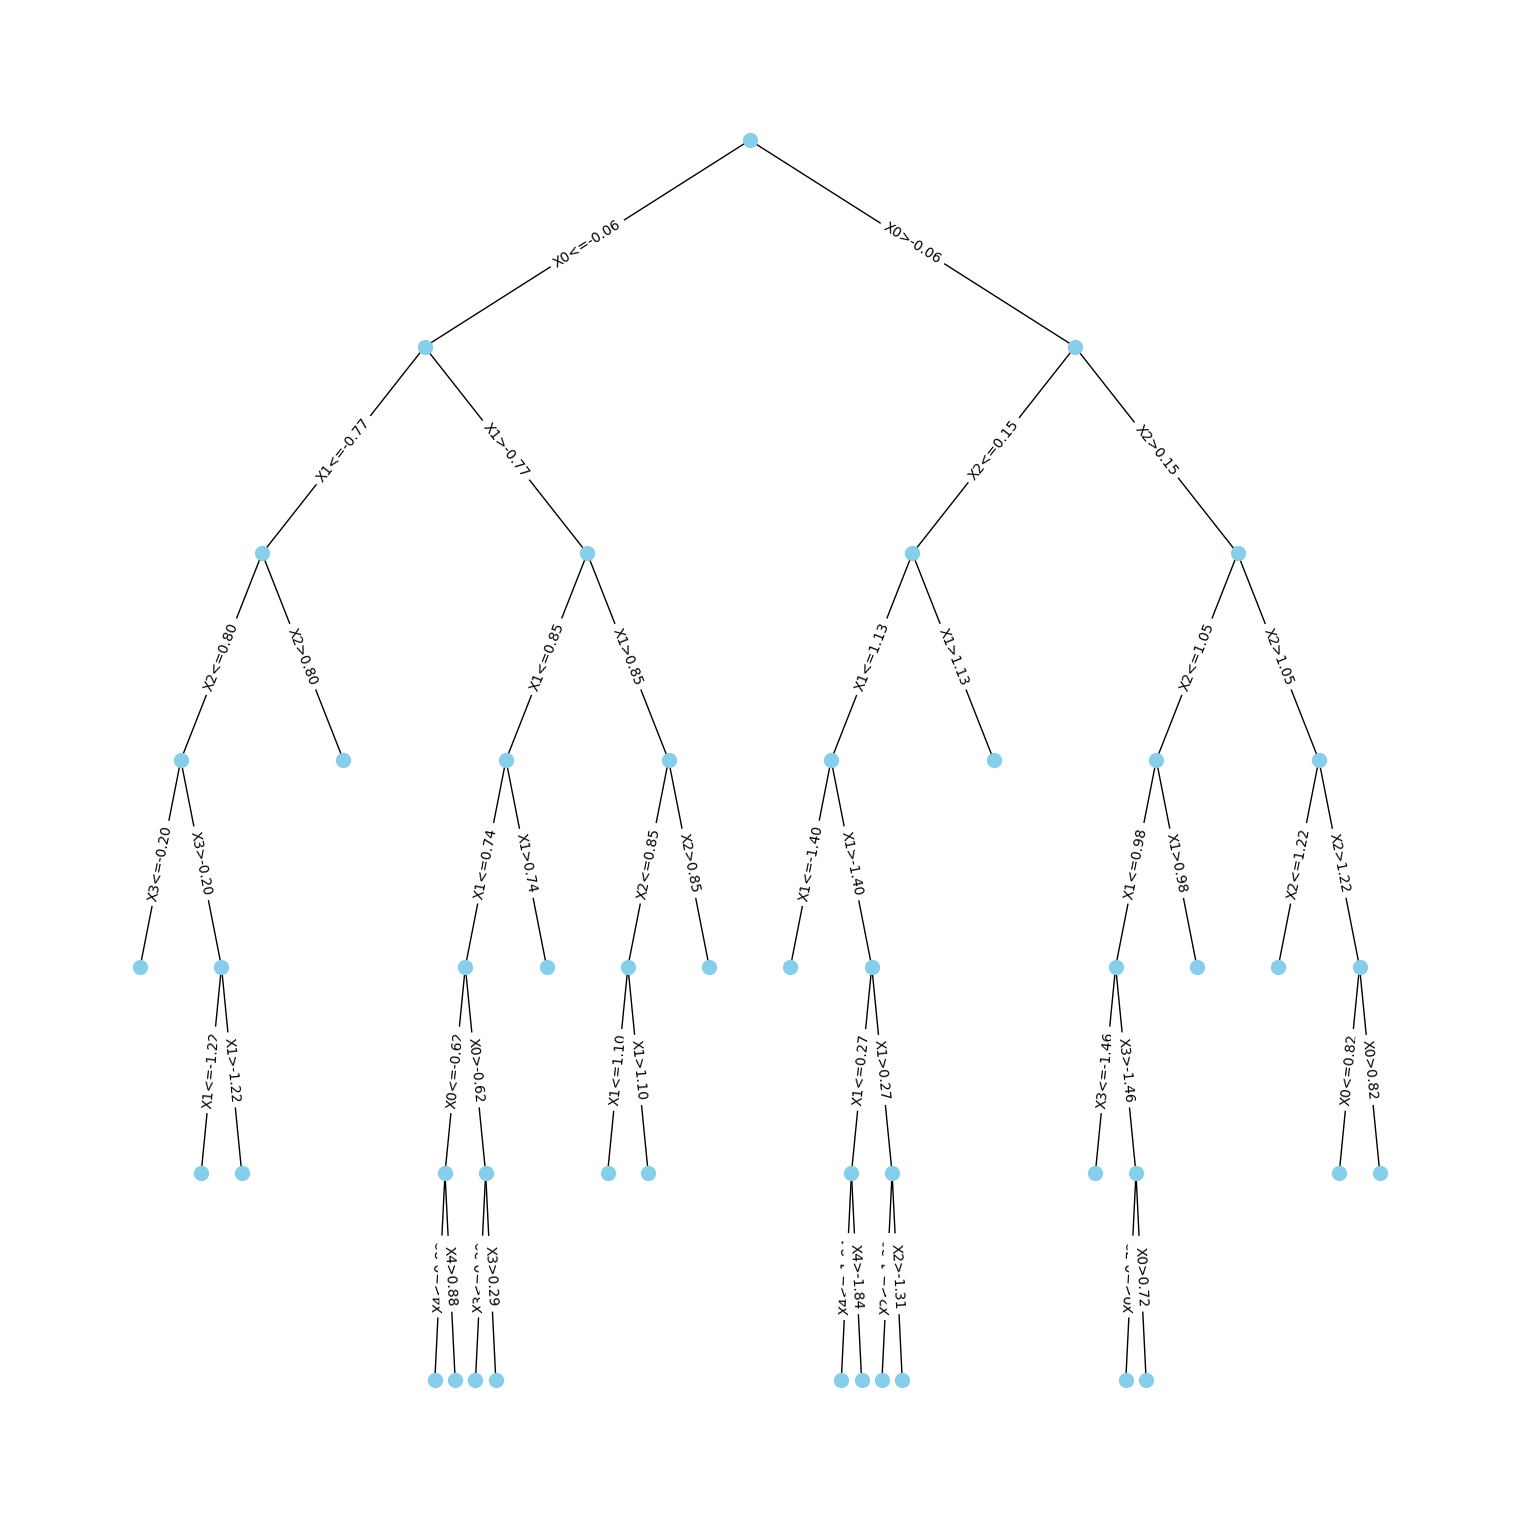

In [9]:
draw_tree(reg_tree.root)

In [32]:
pval, dist, obs, contrast, obs_tar = (
    reg_tree.split_inference(node=reg_tree.root.left.left, 
                             ngrid=10000,
                             ncoarse=50))

(1,)
(99,)
s: 0 j: 0 sopt: 48 jopt: 0
(2,)
(98,)
s: 1 j: 0 sopt: 48 jopt: 0
(3,)
(97,)
s: 2 j: 0 sopt: 48 jopt: 0
(4,)
(96,)
s: 3 j: 0 sopt: 48 jopt: 0
(5,)
(95,)
s: 4 j: 0 sopt: 48 jopt: 0
(6,)
(94,)
s: 5 j: 0 sopt: 48 jopt: 0
(7,)
(93,)
s: 6 j: 0 sopt: 48 jopt: 0
(8,)
(92,)
s: 7 j: 0 sopt: 48 jopt: 0
(9,)
(91,)
s: 8 j: 0 sopt: 48 jopt: 0
(10,)
(90,)
s: 9 j: 0 sopt: 48 jopt: 0
(11,)
(89,)
s: 10 j: 0 sopt: 48 jopt: 0
(12,)
(88,)
s: 11 j: 0 sopt: 48 jopt: 0
(13,)
(87,)
s: 12 j: 0 sopt: 48 jopt: 0
(14,)
(86,)
s: 13 j: 0 sopt: 48 jopt: 0
(15,)
(85,)
s: 14 j: 0 sopt: 48 jopt: 0
(16,)
(84,)
s: 15 j: 0 sopt: 48 jopt: 0
(17,)
(83,)
s: 16 j: 0 sopt: 48 jopt: 0
(18,)
(82,)
s: 17 j: 0 sopt: 48 jopt: 0
(19,)
(81,)
s: 18 j: 0 sopt: 48 jopt: 0
(20,)
(80,)
s: 19 j: 0 sopt: 48 jopt: 0
(21,)
(79,)
s: 20 j: 0 sopt: 48 jopt: 0
(22,)
(78,)
s: 21 j: 0 sopt: 48 jopt: 0
(23,)
(77,)
s: 22 j: 0 sopt: 48 jopt: 0
(24,)
(76,)
s: 23 j: 0 sopt: 48 jopt: 0
(25,)
(75,)
s: 24 j: 0 sopt: 48 jopt: 0
(26,)
(74,)
s: 25 j

Theta setter called


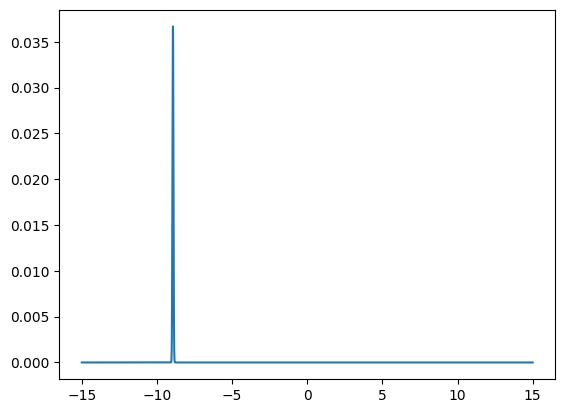

In [34]:
import matplotlib.pyplot as plt
x = np.linspace(-15, 15, 10000)
plt.plot(x, dist.pdf(theta=0))

In [35]:
(contrast/np.linalg.norm(contrast)).T.dot(y)

np.float64(-3.408381058667513)

In [36]:
(contrast/np.linalg.norm(contrast)).T.dot(mu)

np.float64(-0.9341987329938275)

In [37]:
(contrast).T.dot(mu)

np.float64(-0.5454545454545453)

In [39]:
print(pval)

2.320034406640479e-08


# Replicate Tree Value Simulations

In [30]:
X = np.random.normal(size=(100, 10))
a = 1
b = 1
mu = b* ( (X[:,0] <= 0) * (1 + a * (X[:,1] > 0) + (X[:,2] * X[:,1] <= 0)) )
y = mu + np.random.normal(size=(100,), scale=1)

In [31]:
# Create and train the regression tree
reg_tree = RegressionTree(min_samples_split=10, max_depth=10)
reg_tree.fit(X, y)

# Make predictions
predictions = reg_tree.predict(X)
#print(predictions)
reg_tree.print_branches()

 j: 0
 threshold: -0.026246156794562686
 left:
	 j: 8
	 threshold: -0.47691162512272384
	 left:
		 j: 6
		 threshold: -1.882026910030391
		 left:
		 right:
			 j: 5
			 threshold: -0.7006531475942253
			 left:
			 right:
	 right:
		 j: 1
		 threshold: -0.046286560689003074
		 left:
			 j: 4
			 threshold: -0.6951223438765441
			 left:
			 right:
				 j: 1
				 threshold: -1.7342866936815915
				 left:
				 right:
					 j: 9
					 threshold: -0.2666871517794296
					 left:
					 right:
		 right:
			 j: 1
			 threshold: 1.3119538813916485
			 left:
				 j: 5
				 threshold: 0.020045901693990745
				 left:
				 right:
			 right:
 right:
	 j: 6
	 threshold: 1.1256570637586534
	 left:
		 j: 4
		 threshold: 1.461856376611065
		 left:
			 j: 6
			 threshold: -1.7952845350243212
			 left:
			 right:
				 j: 4
				 threshold: -0.4259380811250433
				 left:
					 j: 1
					 threshold: 1.6819463364634613
					 left:
						 j: 8
						 threshold: -0.3066579992144446
						 left:
						 right:
				

In [32]:
contrast = reg_tree.root.left.membership - reg_tree.root.right.membership
nuisance = y - np.linalg.outer(contrast,contrast) @ y / (np.linalg.norm(contrast)**2)

In [33]:
reg_tree.compute_log_ref_measure(node=reg_tree.root, 
                                 grid = np.linspace(-1, 1, num=10),
                                 nuisance=nuisance)

/var/folders/6t/y2p8qwk54f7fnkwds613w0040000gs/T/ipykernel_28254/3873585096.py:215: RuntimeWarning: divide by zero encountered in log
  ref_measure.append(np.log(sel_prob))


array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf])

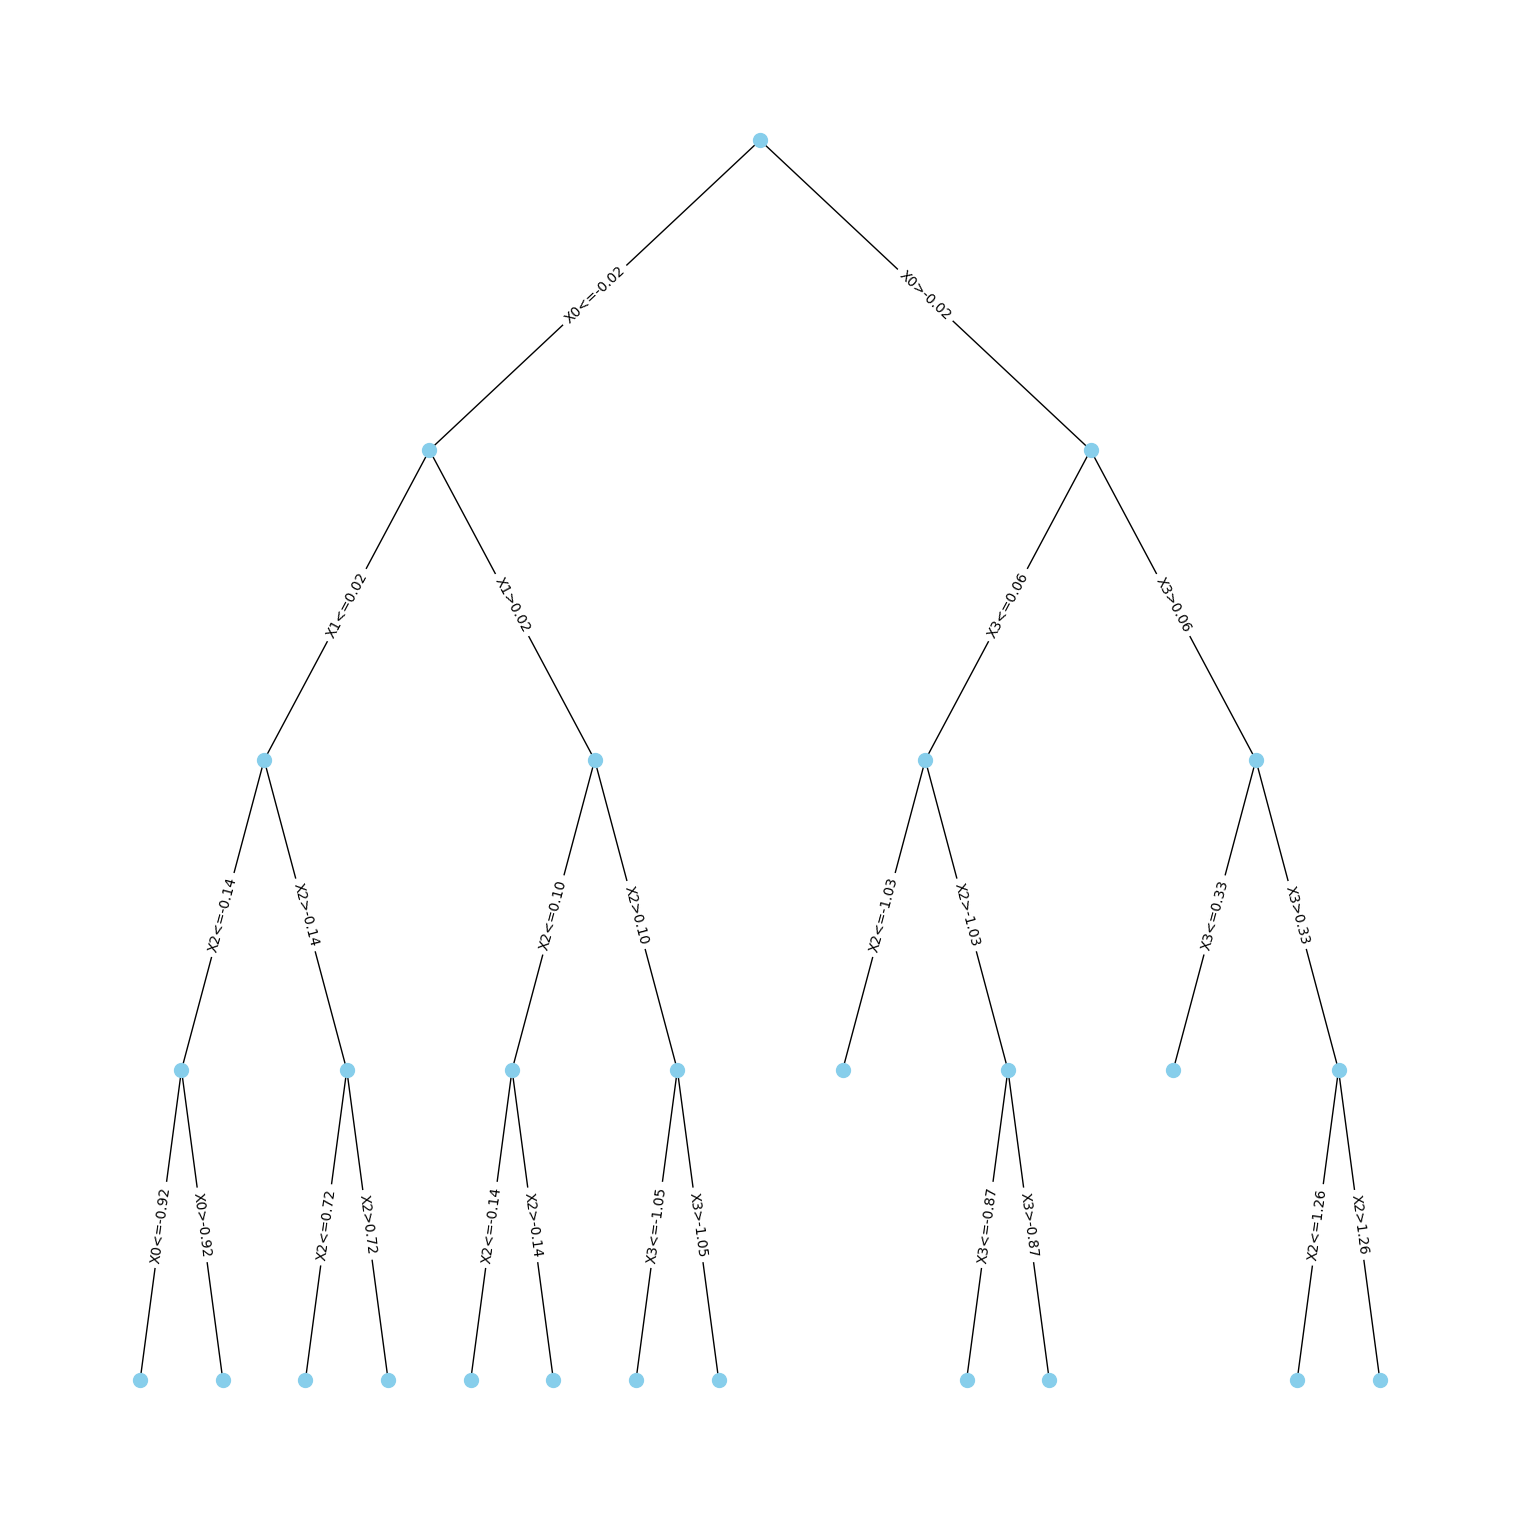

In [331]:
draw_tree(reg_tree.root)